In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## 简单的道具图像识别, 然后部署到安装上, 这是一个完整的流程,做出来一个简单的应用

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

## 编写一个我自己的custom dataset的模型训练

In [4]:
## 读取道具的 爬虫的数据映射
import json
with open("id_mapping_dict.json") as file:
    json_content = json.loads(file.read())

classes = {v['new_id']:v["zh"]+":"+v["desc"] for i, v in json_content.items() if v.get("new_id")!= None}
# classes

(64, 64)


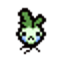

In [5]:
# ls cus_data/
from PIL import Image
dir_path = "cus_data/"
image = Image.open("cus_data/0.png")
print(image.size)
image

# 增加7个随机的背景, 用来合成带背景的图片识别  
这样每个类别的对象就增加到7个这么多了.  

In [6]:
# isinstance?

In [7]:
from PIL import Image
from tqdm import tqdm

# 打开背景图像和对象图像
def add_image_bg(bg_image_path, image_path, output_path):
    background = Image.open(bg_image_path)
    background = background.resize((64, 64))
    object_image = Image.open(image_path)
    background.paste(object_image, (0, 0), mask=object_image)

    # 保存叠加后的图像
    background.save(output_path, "PNG")
    return background

def plot_images(images:Image, images_per_row = 9, figsize=(20,20)):  # pil 的图片才能plot
    plt.figure(figsize=figsize)

    # 获取第一张图片的尺寸，假设所有图片尺寸都相同
    image_width, image_height = images[0].size

    # 计算总的行数
    total_rows = len(images) // images_per_row
    total_rows += len(images) % images_per_row

    # 创建一个新的空白图片，尺寸为所有图片拼接后的尺寸
    canvas_width = images_per_row * image_width
    canvas_height = total_rows * image_height
    canvas = Image.new('RGB', (canvas_width, canvas_height))

    # 逐行逐列粘贴图片
    for i, image in enumerate(images):
        row = i // images_per_row
        col = i % images_per_row

        # 计算当前图片在画布上的位置
        left = col * image_width
        top = row * image_height

        # 粘贴图片
        canvas.paste(image, (left, top))

    # 显示拼接后的图片
#     canvas.show()
    plt.imshow(canvas)
    plt.show()

In [8]:
import os
output_dir = "new_cus_data"
os.makedirs(output_dir, exist_ok=True)
bg_files = [i for i in os.listdir("./cus_background/") if i.find(".")!=0]
meta_images = [i for i in os.listdir("./cus_data/") if i.find(".")!=0]
meta_images.sort(key=lambda x: int(x.split(".png")[0]))
meta_images

new_meta_images = []
for image in tqdm(meta_images[:20]):
    for bg in bg_files:
        bg_path = f"cus_background/{bg}"
        image_path = f"cus_data/{image}"

        output_name = image_path.split("/")[-1].strip("png") + bg_path.split("/")[-1]
        output_path = os.path.join(output_dir, output_name)
        result = add_image_bg(bg_path, image_path, output_path)
#         plt.imshow(result)
#         new_meta_images.append(result)
print("合成完毕")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 26.01it/s]

合成完毕


In [9]:
# plot_images(new_meta_images, figsize=(10, 10))

In [11]:
import torch
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## 构造一个模型

In [12]:
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()
# print(f"device:{device}")
# net.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# # 定义损失函数 和优化器

# 此处 开始 00--------00 直接重新用vgg16做的

In [13]:
from torchvision.io import read_image

class IssacCustomDatasets(Dataset):
    def __init__(self, img_sort_files, 
                 img_dir, transform=None, 
                target_transform=None):
        self.img_labels = img_sort_files
        # 自定义标签关系, 此处需要排好序的
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):  # 作用是获得label 和 item 即可
        filename = self.img_labels[idx]        
        # 因为每个图片有9个, 所以自定义的就重新配置一下 labels index 取元素的操作
        img_path = os.path.join(self.img_dir, filename)
#         image = read_image(img_path)  # 这里也有一个疑惑, 你这个读取的到底是什么格式的东西啊
        image = read_image(img_path, mode=torchvision.io.image.ImageReadMode.RGB)

        label = int(filename.split(".")[0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [14]:
meta_output_dir = "new_mini_20meta_dataset"
os.makedirs(meta_output_dir, exist_ok=True)

from_dir = "new_cus_data"
need_move_images = os.listdir("new_cus_data/")
need_move_images = [i for i in need_move_images if int(i.split(".")[0]) <= 19]
# need_move_images.sort(key=lambda x: int(x.split(".")[:1]))
need_move_images.sort(key=lambda x: f"{int(x.split('.')[0]):03d}" + f"{x.split('.')[1]}")
need_move_images

import shutil
for i in need_move_images:
    shutil.copy(os.path.join(from_dir, i), os.path.join(meta_output_dir, i))

In [15]:
# 自定义读取透明背景png的图片
from torchvision.transforms import ToTensor
        
transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Resize((224, 224)),  # 将图片尺寸调整为224x224 大的话, 训练时间会更长, 那之前是怎么训练的, 麻了.
        # 增加噪声, 防止过拟合, 因为我还是需要一些现实的照片才可以更准确一些.
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1),  # 抖动图像的亮度、对比度、饱和度和色相
        transforms.Lambda(lambda x: x.float()),
#         transforms.Normalize(
#             [43.11019, 42.666084, 42.702415],
#             [100.52347, 99.96471, 100.45631]
#         )  # 对图片数据做正则化
    ])

batch_size = 6

# 需要已经排好序
train_dataset = IssacCustomDatasets(need_move_images, img_dir="new_mini_20meta_dataset/",
                                    transform=transform)
# labels = list(range(len(os.listdir("cus_data"))))
# train_dataset = IssacCustomDatasets(labels, img_dir="cus_data/",
#                                     transform=transform)

## dataloader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
# test_loader = train_dataloader

### 完整类别的版本

In [16]:
from torchvision.models import vgg16
import torch.optim as optim
import numpy as np

In [17]:
# from matplotlib import pyplot as plt
# from torchvision.utils import make_grid

# net = vgg16(num_classes=len(classes))  # 这个倒是完整的
# # net = MobileNetV3(num_classes=len(classes))  # 这个倒是完整的
# net.to(device)  # 重建一个模型, 初始化一个

# criterion = nn.CrossEntropyLoss()
# # optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.0001)
# # 换cell 才可以好一点, 不然会出问题

## 小批量测试的版本

In [18]:
# 获取图片数据的 归一化数值
global_mean = []
global_std = []

for images, labels in train_dataloader:   # dataloader is a DataLoader instance with your dataset
    numpy_image = images.numpy()
    
    # Compute mean and std dev
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    global_mean.append(batch_mean)
    global_std.append(batch_std)

# Final mean and std (use np.mean instead of np.average)
global_mean = np.mean(global_mean, axis=0).tolist()
global_std = np.mean(global_std, axis=0).tolist()
print(global_mean)
print(global_std)

/usr/local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[77.58928680419922, 58.36479568481445, 51.83070755004883]
[46.74263381958008, 38.2352409362793, 34.54035186767578]


In [19]:
# 自定义读取透明背景png的图片
# 根据新的标准差和平均数, 重新运行dataloader
from torchvision.transforms import ToTensor
        
transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Resize((224, 224)),  # 将图片尺寸调整为224x224 大的话, 训练时间会更长, 那之前是怎么训练的, 麻了.
        # 增加噪声, 防止过拟合, 因为我还是需要一些现实的照片才可以更准确一些.
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1),  # 抖动图像的亮度、对比度、饱和度和色相
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(
            global_mean,
            global_std
        )  # 对图片数据做正则化
    ])


# 需要已经排好序
train_dataset = IssacCustomDatasets(need_move_images, img_dir="new_mini_20meta_dataset/",
                                    transform=transform)
# labels = list(range(len(os.listdir("cus_data"))))
# train_dataset = IssacCustomDatasets(labels, img_dir="cus_data/", transform=transform)

## dataloader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
# test_loader = train_dataloader

In [20]:
## 小批量测试
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

net = vgg16(num_classes=20)  # 这个倒是完整的
# net = MobileNetV3(num_classes=20)  # 这个倒是完整的
net.to(device)  # 重建一个模型, 初始化一个  或者我直接用 64 不用于训练模型

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.00001)
# 换cell 才可以好一点, 不然会出问题

In [21]:
# ## 检查一下transform的抖动效果是怎么样的, 
# ## 怀疑这个造成问题了

# # plt.figure(figsize=(5, 5))、
# import numpy as np
# check_images = []
# for i in range(9):
#     plt.figure(figsize=(1, 1))  # 设置图片尺寸为10x8英寸
#     path = f"new_cus_data/1.bg_{i+1}.png"
#     c_image = read_image(path, 
#                         torchvision.io.image.ImageReadMode.RGB)
#     c_image = transform(c_image)
#     npimg = c_image.numpy()
#     #     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     c_image =  np.transpose(npimg, (1, 2, 0))
#     check_images.append(c_image)
    
    
# # plot_images(check_images)
#     plt.imshow(c_image)
#     plt.title(c_image.shape)
#     plt.show()

In [22]:
## 我的目标是解决这个任务, 而不是 玩 无尽的循环游戏,并且没能获得快乐

In [23]:
torch.cuda.empty_cache()

In [35]:
%%time
# 训练模型

# 60 + 60
check_iter = 4 # train check batch size 
train_epoch = 20
prefix = "20240126_"

for epoch in range(train_epoch):
    net.train()  # 每个epoch 后切换训练模式, 那么会不会保留之前的训练权重呢?
    
    progress_bar = tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader))
    for i, data in progress_bar:
        inputs, labels = data  # 必须要float 归一化? 浮点类型.
        inputs, labels = inputs.float().to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)  # 这一步, 运行有问题, 这是为什么呢, 检查一下图片格式

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         print("per batch loss:", loss / batch_size)
        if i % check_iter == 0:    # 每 4 个小批量打印一次损失值
#             print('[epoch: %d, iter_num: %5d] loss: %.3f' % (epoch+1, i + 1, loss / batch_size) )
            progress_bar.set_description(f'epoch:{epoch}, loss: {loss / batch_size:.3f}')
    if epoch % 1 == 0:  # 每两个epoch进行一次验证
        print("开始验证....")
        net.eval()
        correct = 0  # 记录正确预测的数量
        total = 0  # 总的样本数
        with torch.no_grad():
            progress_bar2 = tqdm(enumerate(train_dataloader, 0), total=int(len(train_dataloader) * 0.2))
            for i, data in progress_bar2:
                if i >= int(len(train_dataloader) * 0.2):
                    break
#             for i, data in enumerate(train_dataloader, 0):
                inputs, labels = data
                inputs, labels = inputs.float().to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)

                # 统计准确率
                total += labels.size(0)  # 实际的样本数
                correct += (predicted == labels).sum().item()  # 正确预测的样本数

#                 print('Real: ', labels, ', Predicted: ', predicted)

        accuracy = correct / total * 100  # 计算准确率
        progress_bar2.set_description(f'epoch:{epoch}, Accuracy: {accuracy:.3f}')

#     print()
    if epoch % 5 == 0:
        save_model_path = f"{prefix}_vgg16_{epoch}_{accuracy}.pth"
        torch.save(net.state_dict(), save_model_path)
        print(f"model save: ", save_model_path)
    torch.cuda.empty_cache()
print('Finished Training')

save_model_path = f"{prefix}_vgg16_{epoch}_{accuracy}.pth"
torch.save(net.state_dict(), save_model_path)
print(f"model save: ", save_model_path)

  0%|                                                                                                                                      | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
epoch:0, loss: 0.348: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████

开始验证....


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.28it/s]


model save:  20240126__vgg16_0_72.22222222222221.pth


epoch:1, loss: 0.184:  13%|█████████████▊                                                                                          | 4/30 [00:11<01:13,  2.81s/it]


KeyboardInterrupt: 

In [34]:
int(len(train_dataloader) * 0.2)

6

model save:  20240126__vgg16_19_100.0.pth  
CPU times: user 22min 21s, sys: 3min 49s, total: 26min 11s  
Wall time: 49min 32s  

In [ ]:
labels

In [ ]:
## 大概40个epoch就可以了?

## 用本地的图片进行测试

上面我保存到mps 中执行的保存, 所以后面也需要使用mps才可以? 或者转换成onnx 统一的格式

In [ ]:
new_dict = {v['new_id']:v for i, v in json_content.items() if v.get("new_id")!=None}
new_dict

In [ ]:


model = vgg16(num_classes=20).to(device)
# model.load_state_dict(torch.load(save_model_path))
# model.load_state_dict(torch.load("20240125_13:41__vgg16_0.pth"))
model.load_state_dict(torch.load("20240126__vgg16_10_97.22222222222221.pth"))  # 不用百分百的


def eval_predict(model, image_path):
#     test_img = os.path.join("cus_test_data", test_img)
    image = read_image(image_path, mode=torchvision.io.image.ImageReadMode.RGB)
    # image = image.resize(64, 64)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()
    model.eval()
    timg = transform(image)
    timg = timg.to(device)
    timg1 = timg.unsqueeze(0)
    result = model(timg1)
    result
    _, predicted = torch.max(result, 1)
    print(predicted.item())

    print(predicted.item(), 
          new_dict[predicted.item()]['zh'], 
          new_dict[predicted.item()]['en'],
          new_dict[predicted.item()]['desc'])
    
    probs = torch.nn.functional.softmax(predicted[0], dim=0)
    top_k_values, top_k_indices = torch.topk(probs, 20)
    print("Top 20 categories are: ", top_k_indices)
    

In [ ]:
# ## 打开一个图片, 加一个预处理, 检查一下
# import cv2 

# test_img = "cus_data/2.png"
# print("real label: ", test_img.split("/")[-1])
# # image = read_image()
# # test_img = "/Users/zhengyiming/Downloads/iShot_2024-01-24_16.17.44.png"



# for test_img in os.listdir("cus_test_data/"):
#     print(test_img)
#     if str(test_img).split(".")[-1] not in ["png", "jpeg", "jpg"]:
#         continue
# #     test_img = "cus_test_data/iShot_2024-01-25_14.09.48.png"
#     image_path = os.path.join("cus_test_data", test_img)
#     eval_predict(model, image_path)
#     print()
#     print()

In [ ]:
image_path = "new_cus_data/1.bg_3.png"
image_path = "/Users/zhengyiming/PycharmProjects/Isaac/new_cus_data/2.bg_8.png"

image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_12.22.24.png"

# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_12.16.24.png"
# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_12.16.01.png"
# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_12.17.48.png"
# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_12.16.20.png"

# for i in os.listdir("new_cus_data/"):
#     if i.split(".")[-1] not in ["png", "jpeg", "jpg"]:
#         continue
        
# image_path = os.path.join("new_cus_data", i)

print("real label: ", image_path.split("/")[-1])    
# image_path = os.path.join("cus_test_data", test_img)
eval_predict(model, image_path)

In [ ]:
# probabilities = F.softmax(outputs, dim=1)

# probabilities_percent = probabilities * 100
# for i in range(probabilities_percent.shape[0]):
#     print(f"Image {i+1}:")
#     for j in range(probabilities_percent.shape[1]):
#         print(f"    Class {j}: {probabilities_percent[i][j].item():.2f}%")

In [ ]:
test_img.split(".")[-1]

In [ ]:
# probabilities = F.softmax(outputs, dim=1)

# probabilities_percent = probabilities * 100
# for i in range(probabilities_percent.shape[0]):
#     print(f"Image {i+1}:")
#     for j in range(probabilities_percent.shape[1]):
#         print(f"    Class {j}: {probabilities_percent[i][j].item():.2f}%")

In [ ]:
len(classes)

## 明天把这个模型简单的封装一下, 增加一个前端, 摄像头框选的操作. 试试怎么搞
# 封装起来直接可以用了, 有意思.

In [ ]:
# # save my net model
# print(epoch)
# save_model_path = f"net_{epoch}.pth"
# torch.save(net.state_dict(), save_model_path)

In [ ]:
# load model

In [ ]:
# model = vgg16(num_classes=len(classes)).to(device)
# model.load_state_dict(torch.load(save_model_path))
# model.eval()

In [ ]:
# batch_size

In [ ]:
# predicted.tolist()

In [ ]:
# # 检查模型, 说明模型根本没训练到
# import torch
# # 在测试集上进行推理验证
# correct = 0
# total = 0

# with torch.no_grad():
#     for data in train_dataloader:
#         images, labels = data
# #         images = images.float()

#         ## 并排显示两个图片, 完全没训练到, 这是, loss
#         print(len(labels))
        
#         sub_images = [images[i].numpy().transpose((1, 2, 0))
#                      for i in range(batch_size)]
        
# #         img1 = images[0].numpy().transpose((1, 2, 0))
# #         img2 = images[1].numpy().transpose((1, 2, 0))
# #         combined_img = np.concatenate((img1, img2), axis=1)

#         combined_img = np.concatenate(sub_images, axis=1)
#         plt.imshow(combined_img)
        
#         images = images.float()

        
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
        
#         sub_labels = [new_dict[i]['en'] for i in predicted.tolist()]
#         plt.title(sub_labels)
#         plt.show()  # 归一化, 输入前. 这个倒也是没问题. 

#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# accuracy = 100 * correct / total
# print('Accuracy of the network on the test images: %d %%' % accuracy)


In [ ]:
## vgg 16就足够了

In [ ]:
### 接下来的路线

## 1. 增加训练数据量, 增加数据增强
## 2. 测试和验证简单的 自定义模型

## 3. 继续接下来的部署流程, 
### 3.1 部署到移动设备, 安卓或者 ios
### 3.2 直接部署到安卓本身  

## 4. 图像识别改成 目标检测!  
